# Assignment:4
1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

submission deadline till 9pm friday

submission instruction:
create your github repo and keep all the assisgnments over there(in that github repo)
i will share one googleform in group after completing your assignment you can share the github link through that google form. 

### Config the model

In [510]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(temperature=0.7)
output=model.invoke("hi")
print(output.content)

Hello! How can I help you today?


### Config the embedding model

In [511]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [512]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [513]:
loader=DirectoryLoader("../data2",glob="Internal_HR_Company_Policies.txt",loader_cls=TextLoader)
docs=loader.load()

In [514]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

new_docs=text_splitter.split_documents(documents=docs)
db = Chroma.from_documents(documents=new_docs, embedding=embeddings, persist_directory=None)
retriever = db.as_retriever()

In [515]:
retriever.get_relevant_documents("iran")

[Document(metadata={'source': '../data2/Internal_HR_Company_Policies.txt'}, page_content='and operates in 6 countries. It primarily serves clients in the telecom, BFSI, and healthcare sectors.'),
 Document(metadata={'source': '../data2/Internal_HR_Company_Policies.txt'}, page_content='and operates in 6 countries. It primarily serves clients in the telecom, BFSI, and healthcare sectors.'),
 Document(metadata={'source': '../data2/Internal_HR_Company_Policies.txt'}, page_content='Document Title: Internal HR & Company Policies – Nexora Technologies Pvt. Ltd.\n\nDocument ID: HRPOL-INT-2025-003\nConfidentiality Level: Internal Use Only\nLast Updated: May 15, 2025'),
 Document(metadata={'source': '../data2/Internal_HR_Company_Policies.txt'}, page_content='Document Title: Internal HR & Company Policies – Nexora Technologies Pvt. Ltd.\n\nDocument ID: HRPOL-INT-2025-003\nConfidentiality Level: Internal Use Only\nLast Updated: May 15, 2025')]

In [516]:
import operator
from typing import List
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader

In [517]:
from typing import TypedDict, List
# class AgentState(TypedDict):
#     question: str
#     messages: List[str]
#     last_route: str
#     attempted_routes: List[str]
#     validation_passed: bool
class AgentState(TypedDict, total=False):
    question: str
    answer: str
    route: str
    validated: bool
    retrieved_docs: List[str]  # optional, used in RAG


In [518]:
def initialize_state(question: str) -> AgentState:
    return {
        "question": question,
        "route": None,
        "answer": None,
        "validated": False
    }


In [519]:
def llm_router(state: AgentState) -> AgentState:
    question = state["question"]

    route_prompt = PromptTemplate(
        template="""You are a routing assistant.
Decide the best method to answer the question.
Options:
- "crawler" for live or real-time info
- "rag" for document-based or internal policy questions
- "llm" for general knowledge

Question: {question}
Answer with only one word: crawler, rag, or llm.""",
        input_variables=["question"]
    )
    
    chain = route_prompt | model | StrOutputParser()
    route = chain.invoke({"question": question}).strip().lower()

    return {**state, "route": route}


In [520]:
def hybrid_router(state: AgentState) -> AgentState:
    routed_state = llm_router(state)
    route = routed_state["route"]
    question = routed_state["question"]

    if route == "rag":
        relevant_docs = retriever.get_relevant_documents(question)
        if not relevant_docs:
            routed_state["route"] = "llm"
        else:
            routed_state["retrieved_docs"] = relevant_docs
    return routed_state


In [521]:
hybrid_router({"question": "What is the use of machine learning"})

{'question': 'What is the use of machine learning', 'route': 'llm'}

In [522]:
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

def rag_node(state: AgentState) -> AgentState:
    question = state["question"]
    docs = retriever.get_relevant_documents(question)
    context = format_docs(docs)

    prompt = PromptTemplate(
        input_variables=["context", "question"],
        template="""You are an assistant for question-answering tasks. Use the context below to answer the question briefly. 
If you don't know the answer, just say you don't know.

Context:
{context}

Question: {question}

Answer:"""
    )
    rag_chain = prompt | model | StrOutputParser()
    answer = rag_chain.invoke({"context": context, "question": question})

    return {**state, "answer": answer, "route": "rag"}


In [523]:
def llm_node(state: dict) -> dict:
    question = state["question"]
    answer = model.invoke(question)
    return {**state, "answer": answer, "route": "llm"}

In [524]:
from langchain_community.tools.tavily_search import TavilySearchResults

def crawler_node(state: dict) -> dict:
    question = state["question"]
    search = TavilySearchResults()
    docs = search.invoke({"query": question, "num_results": 3})
    content = "\n".join([doc["content"] for doc in docs])
    prompt = PromptTemplate.from_template("Use this search result to answer: {content}")
    chain = prompt | model | StrOutputParser()
    answer = chain.invoke({"content": content})
    
    return {**state, "answer": answer, "route": "crawler"}


In [525]:
def validate_node(state: dict) -> dict:
    answer = state.get("answer", "")
    # Check for unwanted phrases indicating hallucinations
    bad_phrases = ["As an AI", "I don't have", "cannot access"]
    is_valid = not any(p in answer for p in bad_phrases)
    return {**state, "validated": is_valid}


In [526]:
def supervisor_node(state: dict) -> dict:
    question = state.get("question", "")
    if not question:
        raise ValueError("Question must be provided in the state.")
    
    print("Supervisor received question:", question)
    #state = {"question": question}

    # Route the question
    routed_state = hybrid_router(state)
    route = routed_state.get("route")

    # Pick node based on route
    if route == "llm":
        print("-->Routing to LLM<--")
        routed_state = llm_node(routed_state)
    elif route == "rag":
        print("-->Routing to RAG<--")
        routed_state = rag_node(routed_state)
    elif route == "crawler":
        print("-->Routing to Crawler<--")
        routed_state = crawler_node(routed_state)
    else:
        return {**state, "error": "Unable to route question"}

    # Validate the answer
    routed_state = validate_node(routed_state)

    # If invalid, retry routing once
    if not routed_state.get("validated"):
        print("Validation failed. Re-routing to supervisor.")
        return supervisor_node({"question": question})  # Recursive retry
    else:
        print("Answer passed validation.")

    return routed_state


In [527]:
result = supervisor_node({"question": "Can you tell me about the HR Policy of AT&T regarding employee benefits?"})
print("\n💬 Final Answer:", result)

Supervisor received question: Can you tell me about the HR Policy of AT&T regarding employee benefits?


-->Routing to RAG<--
Validation failed. Re-routing to supervisor.
Supervisor received question: Can you tell me about the HR Policy of AT&T regarding employee benefits?
-->Routing to RAG<--
Validation failed. Re-routing to supervisor.
Supervisor received question: Can you tell me about the HR Policy of AT&T regarding employee benefits?
-->Routing to RAG<--
Validation failed. Re-routing to supervisor.
Supervisor received question: Can you tell me about the HR Policy of AT&T regarding employee benefits?
-->Routing to RAG<--
Validation failed. Re-routing to supervisor.
Supervisor received question: Can you tell me about the HR Policy of AT&T regarding employee benefits?
-->Routing to RAG<--
Validation failed. Re-routing to supervisor.
Supervisor received question: Can you tell me about the HR Policy of AT&T regarding employee benefits?
-->Routing to RAG<--
Answer passed validation.

💬 Final Answer: {'question': 'Can you tell me about the HR Policy of AT&T regarding employee benefits?', 'r

In [528]:
result["answer"]

"I'm sorry, I don't know the specific HR policy of AT&T regarding employee benefits. For clarification, please contact the HR Operations Team."

In [529]:
from langgraph.graph import StateGraph,END
workflow=StateGraph(AgentState)

In [530]:
# workflow.add_node("full_conversation",full_conversation)

In [531]:
workflow.add_node("Supervisor",supervisor_node)

In [532]:
workflow.add_node("rag",rag_node)

In [533]:
workflow.add_node("llm",llm_node)

In [534]:
workflow.add_node("crawler",crawler_node)

In [535]:
workflow.add_node("validate", validate_node)

In [536]:
workflow.set_entry_point("Supervisor")

In [537]:
workflow.add_conditional_edges("Supervisor", lambda x: x["route"], {
    "llm": "llm",
    "rag": "rag",
    "crawler": "crawler"
})

In [538]:
workflow.add_edge("llm", "validate")
workflow.add_edge("rag", "validate")
workflow.add_edge("crawler", "validate")
workflow.add_conditional_edges(
    "validate",
    lambda x: "Supervisor" if not x.get("validated", False) else END,
    {
        "Supervisor": "Supervisor",
        END: END
    }
)


In [539]:
app = workflow.compile()

In [540]:
state = initialize_state("Tell me about the Airplain crash today in 100 words")

In [541]:
state

{'question': 'Tell me about the Airplain crash today in 100 words',
 'route': None,
 'answer': None,
 'validated': False}

In [542]:
result = app.invoke(state)

Supervisor received question: Tell me about the Airplain crash today in 100 words
-->Routing to Crawler<--
Answer passed validation.


In [543]:
result  # This will give you the final answer after validation

{'question': 'Tell me about the Airplain crash today in 100 words',
 'answer': 'The Air India plane, flight AI171, crashed shortly after taking off from Ahmedabad, India on June 12. The crash resulted in the deaths of more than 100 people, with only one survivor, Vishwash Kumar Ramesh. Indian Prime Minister Narendra Modi described the incident as heartbreaking and expressed his condolences to those affected by the tragedy. Rescue operations are ongoing at the crash site, with officials and teams working tirelessly in the aftermath.',
 'route': 'crawler',
 'validated': True}

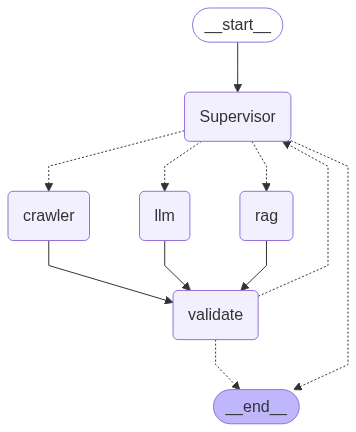

In [544]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))